# Assignment 10/03/2025

## Imports

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

## Image Stitching

### Loading images

In [2]:
image_1 = cv2.imread('./image_stitching_1.jpeg')
image_2 = cv2.imread('./image_stitching_2.jpeg')

In [3]:
image_1 = cv2.cvtColor(image_1, cv2.COLOR_BGR2RGB)
image_2 = cv2.cvtColor(image_2, cv2.COLOR_BGR2RGB)

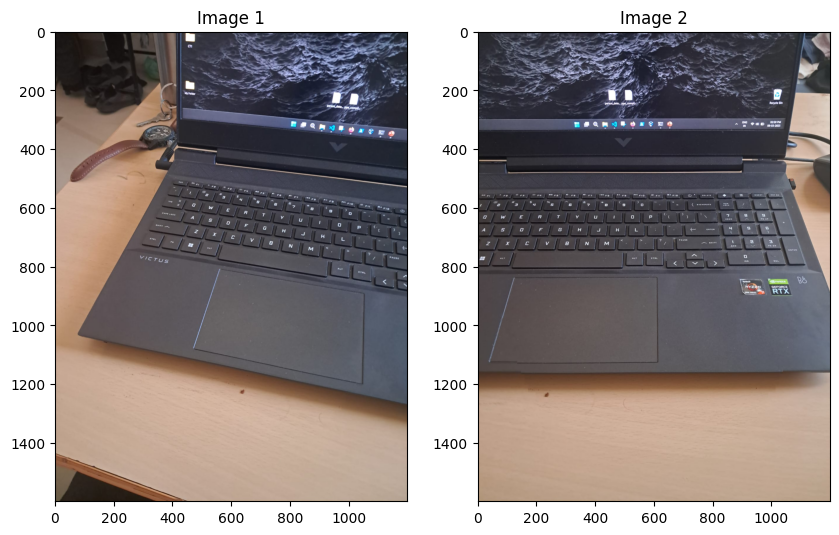

In [4]:
plt.figure(figsize=(10, 10))

plt.subplot(1, 2, 1)
plt.imshow(image_1)
plt.title("Image 1")

plt.subplot(1, 2, 2)
plt.imshow(image_2)
_ = plt.title("Image 2")

### SIFT (Scale-Invariant Feature Transform)

In [5]:
# Detect SIFT keypoints and descriptors in the images
sift = cv2.SIFT_create()
keypoints1, descriptors1 = sift.detectAndCompute(image_1, None)
keypoints2, descriptors2 = sift.detectAndCompute(image_2, None)

In [6]:
# Use the BFMatcher to find the best matches between the descriptors
bf = cv2.BFMatcher()
matches = bf.knnMatch(descriptors1, descriptors2, k=2)

threshold = 0.85
good_points = []
good_matches=[]
for m, n in matches:
    if m.distance < threshold * n.distance:
        good_points.append((m.trainIdx, m.queryIdx))
        good_matches.append(m)

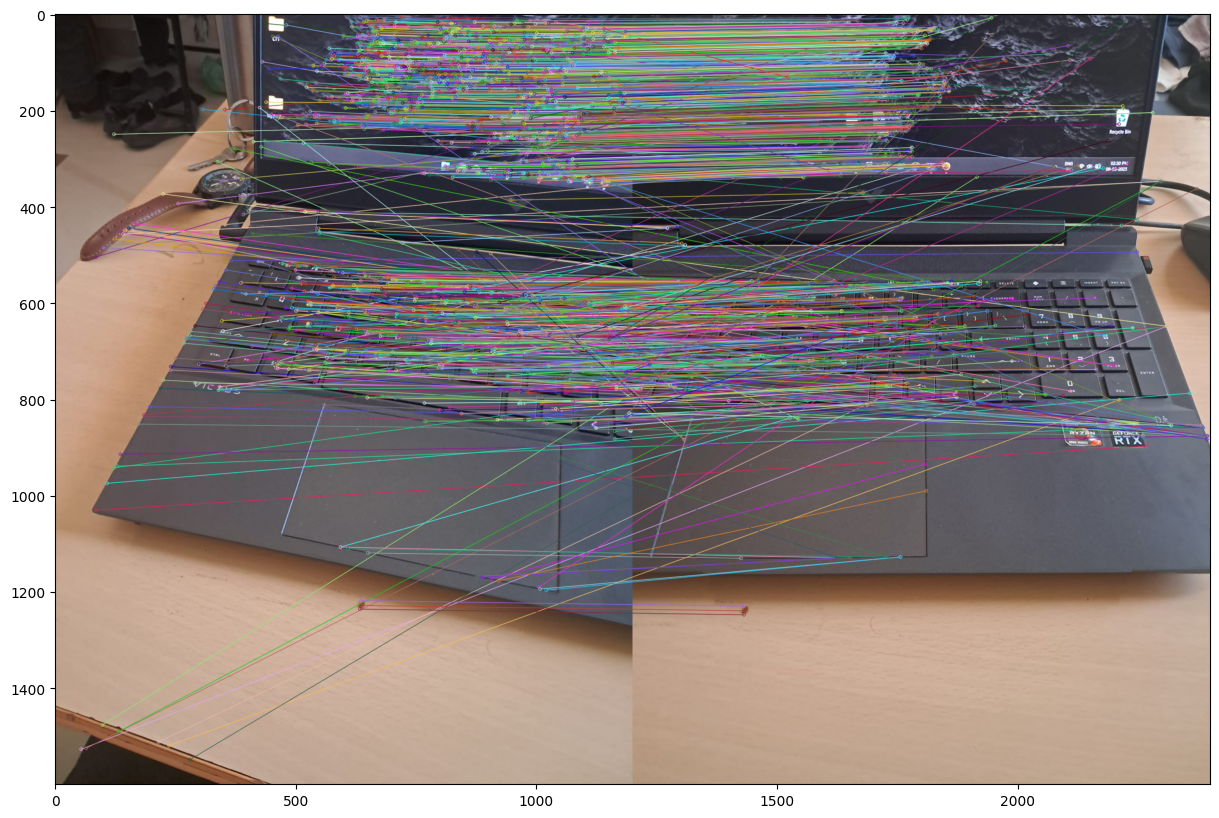

In [7]:
# Draw the matches on the images, display the results
img_matches = cv2.drawMatches(image_1, keypoints1, image_2, keypoints2, good_matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

plt.figure(figsize = (20,10))
plt.imshow(img_matches)

### Homography - RANSAC

In [8]:
# REFERENCING: https://github.com/linrl3/Image-Stitching-OpenCV for the below steps
min_match=10

if len(good_points) > min_match:
    image1_kp = np.float32(
        [keypoints1[i].pt for (_, i) in good_points])
    image2_kp = np.float32(
        [keypoints2[i].pt for (i, _) in good_points])
    H, status = cv2.findHomography(image2_kp, image1_kp, cv2.RANSAC,5.0)

### Creating stitched image

In [9]:
# Setting up dimensions of stitched image
height_img1 = image_1.shape[0]
width_img1 = image_1.shape[1]
width_img2 = image_2.shape[1]
height_panorama = height_img1
width_panorama = width_img1 + width_img2

In [10]:
# Creating masks for left and right image
smoothing_window_size = 800
barrier = width_img1 - smoothing_window_size // 2
offset = smoothing_window_size // 2

# Left mask
mask = np.zeros((height_panorama, width_panorama))
mask[:, barrier - offset:barrier + offset ] = np.tile(np.linspace(1, 0, 2 * offset ).T, (height_panorama, 1))
mask[:, :barrier - offset] = 1

mask_left = cv2.merge([mask] * 3)

# Right mask
mask = np.zeros((height_panorama, width_panorama))
mask[:, barrier - offset :barrier + offset ] = np.tile(np.linspace(0, 1, 2 * offset ).T, (height_panorama, 1))
mask[:, barrier + offset:] = 1

mask_right = cv2.merge([mask] * 3)

In [11]:
# Final panorama creation
panorama1 = np.zeros((height_panorama, width_panorama, 3))
panorama1[0:height_img1, 0:width_img1, :] = image_1
panorama1 *= mask_left
panorama2 = cv2.warpPerspective(image_2, H, (width_panorama, height_panorama)) * mask_right

In [12]:
# Combine both images
result = panorama1 + panorama2

rows, cols = np.where(result[:, :, 0] != 0)
min_row, max_row = min(rows), max(rows) + 1
min_col, max_col = min(cols), max(cols) + 1
final_result = result[min_row:max_row, min_col:max_col, :]

In [13]:
_ = cv2.imwrite('./panorama.png', final_result)

## Face Detection

### Image loading, conversion to grayscale

In [14]:
face_detect_image = cv2.imread('./face_detection.jpg')
grayscale_face_detect = cv2.cvtColor(face_detect_image, cv2.COLOR_BGR2GRAY)
face_detect_image = cv2.cvtColor(face_detect_image, cv2.COLOR_BGR2RGB)

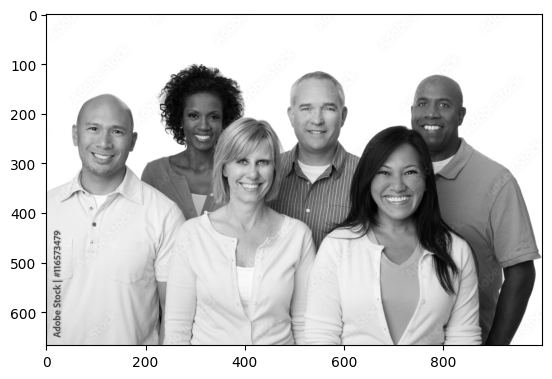

In [15]:
_ = plt.imshow(grayscale_face_detect, cmap='gray')

### Creating Cascade Classifiers

In [16]:
face_cascade = cv2.CascadeClassifier('C:/Users/homea/AppData/Local/Programs/Python/Python311/Lib/site-packages/cv2/data/haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier('C:/Users/homea/AppData/Local/Programs/Python/Python311/Lib/site-packages/cv2/data/haarcascade_eye.xml')
smile_cascade = cv2.CascadeClassifier('C:/Users/homea/AppData/Local/Programs/Python/Python311/Lib/site-packages/cv2/data/haarcascade_smile.xml')

In [17]:
detected_faces = face_cascade.detectMultiScale(grayscale_face_detect)

### Detection of Eyes, Smiles within Faces

In [18]:
face_detect_image = face_detect_image.copy()
eye_detect_image = face_detect_image.copy()
smile_detect_image = face_detect_image.copy()

In [19]:
for (x, y, w, h) in detected_faces:
    cv2.rectangle(face_detect_image, (x, y), (x + w, y + h), (0, 255, 0), 2)

    # Region of interest (ROI) for eyes and smile detection
    roi_gray = grayscale_face_detect[y:y+h, x:x+w]

    detected_eyes = eye_cascade.detectMultiScale(roi_gray)
    for (ex, ey, ew, eh) in detected_eyes:
        cv2.rectangle(eye_detect_image, (x+ex, y+ey), (x+ex+ew, y+ey+eh), (0, 255, 0), 2)

    detected_smiles = smile_cascade.detectMultiScale(roi_gray, scaleFactor=1.8, minNeighbors=10)
    for (sx, sy, sw, sh) in detected_smiles:
        cv2.rectangle(smile_detect_image, (x+sx, y+sy), (x+sx+sw, y+sy+sh), (0, 255, 0), 2)

### Plotting results

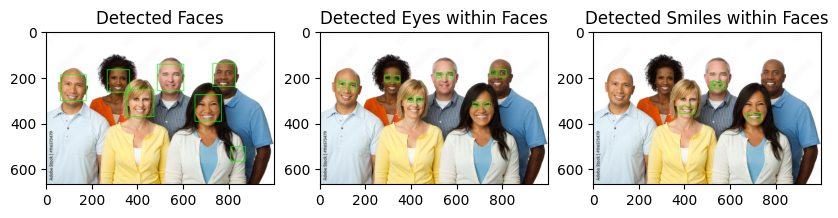

In [20]:
plt.figure(figsize=(10, 15))

plt.subplot(1, 3, 1)
plt.imshow(face_detect_image)
plt.title("Detected Faces")

plt.subplot(1, 3, 2)
plt.imshow(eye_detect_image)
plt.title("Detected Eyes within Faces")

plt.subplot(1, 3, 3)
plt.imshow(smile_detect_image)
plt.title("Detected Smiles within Faces")

plt.show()